# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
# from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# Using prettyTable for showing the observations
from prettytable import PrettyTable
table = PrettyTable()
table.field_names= ["Vectorizer","Model","Hyperparameters","AUC Score"]
print(table)

+------------+-------+-----------------+-----------+
| Vectorizer | Model | Hyperparameters | AUC Score |
+------------+-------+-----------------+-----------+
+------------+-------+-----------------+-----------+


In [4]:
dir_path = '../'
print(os.listdir(dir_path))

['Assignment1_Habermans', 'models', 'database.sqlite', 'Assignment5_LogisticRegression', 'Assignment4_NaiveBayes', 'Assignment2_AmazonFoodReviews', 'Assignment3_kNN', 'Assignment6_SGD', 'Assignment7_SVM']


In [6]:
# using SQLite Table to read data.
con = sqlite3.connect(dir_path+'database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 
# data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE 
# Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score < 3 LIMIT 50000", con)
filtered_data = filtered_data.append(
            pd.read_sql_query(
            "SELECT * FROM Reviews WHERE Score > 3 LIMIT 50000", con))


# Give reviews with Score>3 a positive rating(1), and reviews with a 
# score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
1,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
2,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...


In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [9]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [10]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', 
                              axis=0, ascending=True, inplace=False, 
                              kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName",
                           "Time","Text"}, keep='first', inplace=False)
final.shape

(83317, 10)

In [14]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

83.317

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [15]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [17]:
#Before starting the next phase of preprocessing lets see the 
# number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(83315, 10)


1    45420
0    37895
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further<br> 
with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is<br>
no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-\
# how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.
This stuff tasted so terrible that I had to spit it out before any more of the content permeated my poor mouth. Most people around me wouldn't take up the dare to try one because of the hamster-cage smell drifting out of the bag. The couple people who tried couldn't keep it down. Listen, it's very hard to change your lifestyle, and cookies are more than just food that's bad for you. Cookies make a person feel good, it's true. But if regular cookies have been removed from your menu, try to find something else. Anything else.
These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I'm so glad this seller. I

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These rose buds from Catey13 are precious. They have a soft aroma and a pretty look to them. I plan to use them for small sachets in the bags I bought from catey13, and use rose-colored ribbon to adorn the bags. I am so glad this seller. I bought several things from her and she gave me a refund on the combined shipping costs.


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is one of the best children's books ever written but it is a mini version of the book and was not portrayed as one.  It is over priced for the product.  I sent an email regarding my bewilderment  to Amazon and got no response.


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These rose buds from Catey13 are precious They have a soft aroma and a pretty look to them I plan to use them for small sachets in the bags I bought from catey13 and use rose colored ribbon to adorn the bags I am so glad this seller I bought several things from her and she gave me a refund on the combined shipping costs 


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved 
# in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours',\
                'ourselves', 'you', "you're", "you've",\
"you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him',\
                'his', 'himself', \
'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', \
                'they', 'them', 'their',\
'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',\
                "that'll", 'these', 'those', \
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',\
                'had', 'having', 'do', 'does', \
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', \
                'as', 'until', 'while', 'of', \
'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',\
                'during', 'before', 'after',\
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',\
                'over', 'under', 'again', 'further',\
'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',\
                'any', 'both', 'each', 'few', 'more',\
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than',\
                'too', 'very', \
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",\
                'now', 'd', 'll', 'm', 'o', 're', \
've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',\
                "didn't", 'doesn', "doesn't", 'hadn',\
"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",\
                'ma', 'mightn', "mightn't", 'mustn',\
"mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',\
                "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
review_score = []
# tqdm is for printing the status bar
for sentence, score in tqdm(final[['Text', 'Score']].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() \
                        if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())
    review_score.append(score)

100%|██████████| 83315/83315 [00:27<00:00, 2978.27it/s]


In [27]:
preprocessed_reviews[1500]

'rose buds precious soft aroma pretty look plan use small sachets bags bought use rose colored ribbon adorn bags glad seller bought several things gave refund combined shipping costs'

In [28]:
len(preprocessed_reviews)

83315

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [29]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
preprocessed_summary = []
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z0-9]+', ' ', summary)   # adding 0-9 in the regex
    summary = ' '.join(e.lower() for e in summary.split()\
                       if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 83315/83315 [00:17<00:00, 4788.63it/s]


In [30]:
len(preprocessed_summary)

83315

In [31]:
preprocessed_text = [str(rev+' '+summ) for rev, summ in \
                     zip(preprocessed_reviews, preprocessed_summary)]
print(preprocessed_text[:5])

['one best children books ever written mini version book not portrayed one priced product sent email regarding bewilderment amazon got no response awesome book poor size', 'give five stars maurice sendak story one star printed edition book children older copy book familiar previous softcover version ordered granddaughters embarrassed give gift looks puny book size postcard think overpriced learned lesson not buying softcover children books next time get used copy story great softcover book disappointing', 'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports made china', 'dogs love saw pet store tag attached regarding made china satisfied safe dog lover delites', 'received containers previously opened seals opened top containers decent pieces liver grisley pieces lot powder bottom never buy liver treats amazon big rip review freeze dried liver treats dogs']


In [32]:
# importing train_test_split to split data
from sklearn.model_selection import train_test_split

In [35]:
# this is random splitting into train, test and cross validation set
ppText_train, ppText_test, rs_train, rs_test = train_test_split(
                            preprocessed_text, review_score,
                            test_size=0.30, random_state = 0,
                            stratify = review_score) 

In [38]:
print("Train data length ", len(ppText_train))
print("Test data length ", len(ppText_test))

Train data length  58320
Test data length  24995


In [39]:
ppText_train[:3]

['bought emergen c normal vitamins not work good one everytime feel beginning get sick start taking stops symptoms day amazing love not getting sick flew anymore would recommend best',
 'works chicken fish beef pork fast easy makes taste excellent plus buying bulk box stores awesome stuff',
 'package label looks different one says mount sterling goat milk feta greek style used buy lots loved nice crumbly salads omelets bunch recipes flavoful long shelf life not surprised opened package crumble salad not crumbly no different sliceable cheese figured labeling mistake returned store later thing returned store dug bottom heap found last packages real feta even see difference outside package part description website dry crumbly cheese excellent dishes vegetables label picture exactly one buy looked today emailed mount sterling politely explaing situation figured would want know received curt reply telling welcome return store month ago decided try even though still not look like feta packag

# [4] Featurization

## [4.1] BAG OF WORDS

In [40]:
#BoW
fullPath = dir_path+'models/'+'bow_vectors.pickle'
useOldData = True
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10,
                          max_features=5000) #in scikit-learn
count_vect.fit(ppText_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        bow_train, bow_test = pickle.load(f)
    
else:
    bow_train = count_vect.transform(ppText_train)
    bow_test = count_vect.transform(ppText_test)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump((bow_train, bow_test), f)

print("\nShapes After Vectorization ")
print("Train shape ", bow_train.shape, len(rs_train))
print("Test shape  ", bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

some feature names  ['able', 'able find', 'able get', 'absolute', 'absolute favorite', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no']
Reading vectors from drive..

Shapes After Vectorization 
Train shape  (58320, 5000) 58320
Test shape   (24995, 5000) 24995
Unique words in training :  5000


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation 
#http://scikit-learn.org/stable/modules/generated/
#sklearn.feature_extraction.text.CountVectorizer.html

count_vect_bi = CountVectorizer(ngram_range=(1,2), min_df=10, 
                                max_features=5000)
final_bigram_counts = count_vect_bi.fit_transform(preprocessed_text)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", 
                    final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (83315, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [41]:
fullPath = dir_path+'models/'+'tfIdf_vectors.pickle'
useOldData=True
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,
                             max_features=5000)
tf_idf_vect.fit(ppText_train)
print("Some sample features(unique words in the training corpus)",
    tf_idf_vect.get_feature_names()[0:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        tfIdf_train, tfIdf_test = pickle.load(f)
    
else:
    tfIdf_train = tf_idf_vect.transform(ppText_train)
    tfIdf_test = tf_idf_vect.transform(ppText_test)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump((tfIdf_train, tfIdf_test), f)


print("\nShapes After Vectorization ")
print("Train shape ", tfIdf_train.shape, len(rs_train))
print("Test shape  ", tfIdf_test.shape, len(rs_test))
print("Unique words in training : ", tfIdf_train.get_shape()[1])

Some sample features(unique words in the training corpus) ['able', 'able find', 'able get', 'absolute', 'absolute favorite', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no']
Reading vectors from drive..

Shapes After Vectorization 
Train shape  (58320, 5000) 58320
Test shape   (24995, 5000) 24995
Unique words in training :  5000


## [4.4] Word2Vec

In [42]:
# Train your own Word2Vec model using your own text corpus
i=0

# list of sentences divided into train and test set
train_sentences = [sentence.split() for sentence in ppText_train]
test_sentences = [sentence.split() for sentence in ppText_test]

In [43]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True
fullPath = dir_path+'models/'+'w2V_model.pickle'
useOldData=True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    if os.path.isfile(fullPath) and useOldData:
        with open(fullPath, 'rb') as f:
            w2v_model = pickle.load(f)
    else:
        w2v_model=Word2Vec(train_sentences,min_count=5,size=128, workers=4)
        # Save word2Vec model
        with open(fullPath,'wb') as f:
            pickle.dump(w2v_model, f)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(
                      'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep \
          want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8134129047393799), ('fantastic', 0.7916662693023682), ('excellent', 0.7807477712631226), ('terrific', 0.7619752883911133), ('wonderful', 0.7503091096878052), ('good', 0.7279794812202454), ('perfect', 0.684151828289032), ('amazing', 0.6613575220108032), ('nice', 0.6196218729019165), ('fabulous', 0.6102997064590454)]
[('nastiest', 0.7822471857070923), ('greatest', 0.6812180280685425), ('disgusting', 0.6689467430114746), ('grossest', 0.6398121118545532), ('best', 0.6092371940612793), ('weakest', 0.6060304641723633), ('terrible', 0.5948117971420288), ('weirdest', 0.5907611846923828), ('vile', 0.5707257986068726), ('awful', 0.5698878765106201)]


In [44]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15456
sample words  ['little', 'disappointed', 'mild', 'tried', 'brewing', 'stronger', 'not', 'cup', 'tea', 'great', 'singapore', 'satay', 'favourite', 'food', 'sauce', 'much', 'tamarind', 'peanuts', 'ground', 'finely', 'like', 'eating', 'coarse', 'sugar', 'brand', 'makes', 'better', 'could', 'find', 'let', 'back', 'sure', 'note', 'marinade', 'bottom', 'expecting', 'rising', 'pizza', 'crust', 'might', 'get', 'standard', 'dough', 'need', 'look', 'elsewhere', 'said', 'pretty', 'good', 'right']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [45]:
fullPath = dir_path+'models/'+'avg_W2V.pickle'
useOldData=True

# average Word2Vec

avgW2V_train, avgW2V_test = [], []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        avgW2V_train, avgW2V_test = pickle.load(f)
    
else:
    for i, sent_set in enumerate([train_sentences, test_sentences]):
        for sent in sent_set:
            c += 1
            if c % 1000==0:
                print("Progress : {:3d} %  ".format(
                        int(c/len(preprocessed_reviews)*100)),
                        end='\r')
            sent_vec = np.zeros(128)
            cnt_words = 0
            for word in sent:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    sent_vec += vec
                    cnt_words += 1
            if cnt_words != 0:
                sent_vec /= cnt_words
            if i==0:
                avgW2V_train.append(sent_vec)
            if i==1:
                avgW2V_test.append(sent_vec)
  
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump((avgW2V_train, avgW2V_test), f)

print("Dims of Train : ({}, {})".format(len(avgW2V_train), 
                                        len(avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(avgW2V_test), 
                                       len(avgW2V_test[0])))

Vectors loaded from drive..
Dims of Train : (58320, 128)
Dims of Test : (24995, 128)


#### [4.4.1.2] TFIDF weighted W2v

In [46]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=5)
tf_idf_matrix = model.fit_transform(ppText_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [47]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, 
# col=word and cell_val = tfidf

fullPath = dir_path+'models/'+'tfIdf_avg_W2V.pickle'
useOldData=True

tfidf_avgW2V_train, tfidf_avgW2V_test = [], []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        tfidf_avgW2V_train, tfidf_avgW2V_test = pickle.load(f)
    
else:
    for i, sent_set in enumerate([train_sentences, test_sentences]):
        for sent in sent_set:
            c += 1
            if c % 1000==0:
                print("Progress : {:3d} %  ".format(
                        int(c/len(preprocessed_reviews)*100)), 
                        end='\r')
            sent_vec = np.zeros(128)
            weight_sum = 0
            for word in sent:
                if word in w2v_words and word in tfidf_feat:
                    vec = w2v_model.wv[word]
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
            if weight_sum != 0:
                sent_vec /= weight_sum
            if i==0:
                tfidf_avgW2V_train.append(sent_vec)
            if i==1:
                tfidf_avgW2V_test.append(sent_vec)
              
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump((tfidf_avgW2V_train, tfidf_avgW2V_test), f)
    

print("Dims of Train : ({}, {})".format(len(tfidf_avgW2V_train), 
                                        len(tfidf_avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(tfidf_avgW2V_test), 
                                       len(tfidf_avgW2V_test[0])))

Vectors loaded from drive..
Dims of Train : (58320, 128)
Dims of Test : (24995, 128)


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

In [48]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, roc_curve, auc \
                , accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [228]:
def SgdSvm_Classifier(X_train, y_train):
    alphaList = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, \
                        1, 10, 50, 100, 500, 1000, 5000, 10000])
    params_dict = [{'alpha': alphaList}]
    sgd_optimal = SGDClassifier(loss='hinge', penalty='l2',
                                n_jobs=-1)
    
    grid = GridSearchCV(estimator=sgd_optimal, 
                        param_grid=params_dict, 
                        scoring='roc_auc', n_jobs=4, cv=5)
    
    grid_result = grid.fit(X_train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
    
    plt.figure(figsize=(10.0, 8.0))
    plt.plot(np.log10(alphaList), train_auc, label='Train AUC vs Alpha')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(np.log10(alphaList), train_auc - train_auc_std, 
                          train_auc + train_auc_std, alpha=0.2, color='darkblue')
    
    plt.plot(np.log10(alphaList), cv_auc, label='CV AUC vs Alpha')
    plt.gca().fill_between(np.log10(alphaList), cv_auc - cv_auc_std, 
                          cv_auc + cv_auc_std, alpha=0.2, color='darkorange')
    
    plt.title('Area under ROC vs Alpha')
    plt.xlabel('Alpha')
    plt.ylabel('Area')
    plt.legend(loc='lower left')
    plt.show()   

In [178]:
def SgdSvm_Classifier_Test(alpha, X_train, y_train, X_test, y_test):
    # Setting up the classifier using optimal params

    sgd_optimal = SGDClassifier(loss='hinge', alpha=alpha,
                                penalty='l2', 
                                n_jobs=-1)
    # we have to fit the SGDClassifier so that we can access the coef_
    sgd_optimal.fit(X_train, y_train)
    calibrator = CalibratedClassifierCV(sgd_optimal, cv=5, 
                                        method='isotonic')
    # Lets refit the calibrator to find probabilities
    calibrator.fit(X_train, y_train)
    
    # Prediction on training and test set using optimal classifier
    logProb_train = calibrator.predict_proba(X_train)
    logProb_test = calibrator.predict_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    print("Using Alpha value for sgd-SVM - ", alpha)
    print("Train accuracy for optimal sgd-SVM ", round(
                        accuracy_score(y_train, pred_train)*100, 2))
    print("Test accuracy for optimal sgd-SVM ", round(
                        accuracy_score(y_test, pred_test) * 100, 2))

    # ROC-AUC on train & test data
    train_fpr, train_tpr, thresholds = roc_curve(y_train, 
                                logProb_train[:, 1], pos_label=1)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, 
                                logProb_test[:, 1], pos_label=1)


    # Draw ROC curve
    plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(
                                    auc(train_fpr, train_tpr), 2)))
    auc_score = round(auc(test_fpr, test_tpr), 2)
    plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
    plt.legend()
    plt.xlabel("False Pos Rate")
    plt.ylabel("True Pos Rate")
    plt.title("ROC Curve of Train and Test")
    plt.show()
    
    return sgd_optimal, pred_train, pred_test, auc_score

In [177]:
def draw_Confusion_Matrix(actual, predicted):
    class_label = ["negative", "positive"]
    conf_matrix = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
    hm = sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

Optimal Parameters :  {'alpha': 0.001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': None, 'n_iter': None, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': None, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
(16,)
(16,)


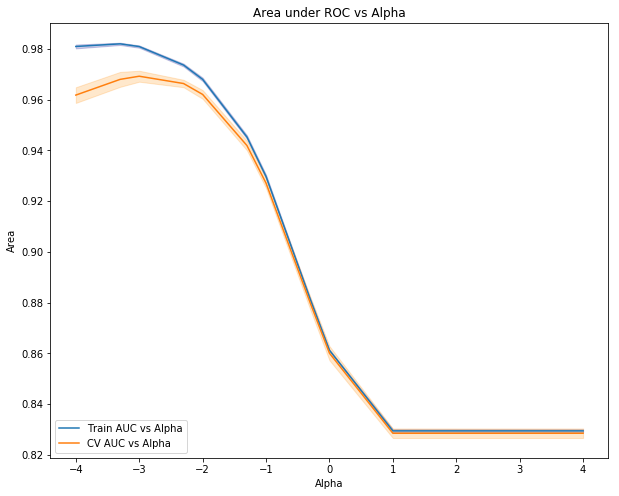

In [126]:
# Please write all the code with proper documentation
SgdSvm_Classifier(bow_train, rs_train)

Using Alpha value for sgd-SVM -  0.001
Train accuracy for optimal sgd-SVM  94.11
Test accuracy for optimal sgd-SVM  92.53


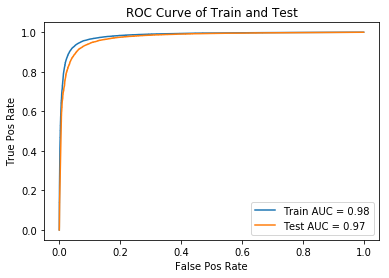

In [140]:
# Please write all the code with proper documentation
bow_alpha=0.001
classifier, pred_train, pred_test, auc_score = SgdSvm_Classifier_Test(
                                    bow_alpha, bow_train, 
                                    rs_train, bow_test, 
                                    rs_test)

Training Confusion Matrix


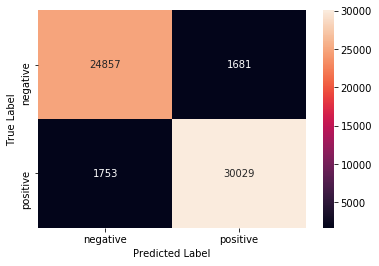




Test Confusion Matrix


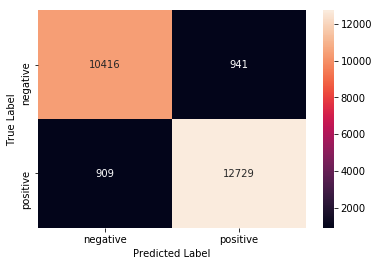

In [128]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["BOW", "SGD Linear SVM", bow_alpha, 
               auc_score])

In [129]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     11357
           1       0.93      0.93      0.93     13638

   micro avg       0.93      0.93      0.93     24995
   macro avg       0.93      0.93      0.93     24995
weighted avg       0.93      0.93      0.93     24995



In [141]:
# Please write all the code with proper documentation
zero_w = classifier.coef_.size - np.count_nonzero(classifier.coef_)
total_w = classifier.coef_.size
print("Sparsity :  {} %".format(round((zero_w*100)/total_w ,2)))

Sparsity :  0.0 %


In [146]:
# Top 10 positive features
print("Top 10 positive features are : ")
print(np.take(count_vect.get_feature_names(), 
              classifier.coef_[0].argsort()[:-11:-1]))

Top 10 positive features are : 
['not disappointed' 'excellent' 'delicious' 'awesome' 'not bad' 'yummy'
 'best' 'perfect' 'yum' 'loves']


In [147]:
# Top 10 negative features
print("Top 10 Negative features are : ")
print(np.take(count_vect.get_feature_names(), 
              (-classifier.coef_[0]).argsort()[:-11:-1]))

Top 10 Negative features are : 
['not good' 'disappointing' 'not worth' 'worst' 'disappointed' 'terrible'
 'awful' 'horrible' 'not great' 'disappointment']


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

Optimal Parameters :  {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': None, 'n_iter': None, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': None, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
(16,)
(16,)


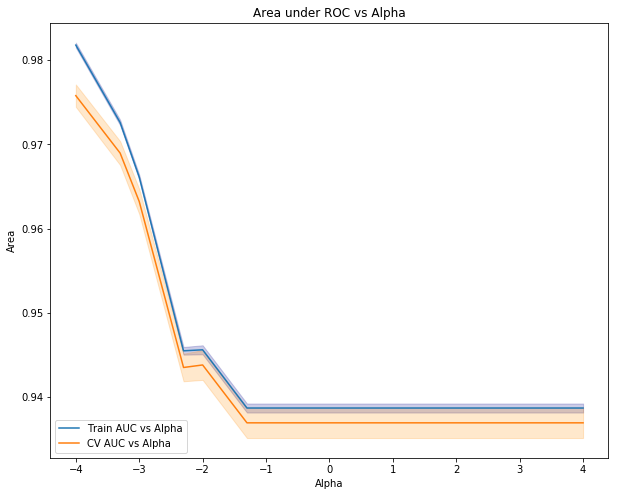

In [156]:
# Please write all the code with proper documentation
SgdSvm_Classifier(tfIdf_train, rs_train)

Using Alpha value for sgd-SVM -  0.0001
Train accuracy for optimal sgd-SVM  93.46
Test accuracy for optimal sgd-SVM  92.47


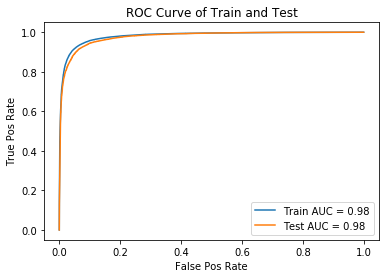

In [157]:
# Please write all the code with proper documentation
tfIdf_alpha=0.0001
classifier, pred_train, pred_test, auc_score = SgdSvm_Classifier_Test(
                                    tfIdf_alpha, tfIdf_train, 
                                    rs_train, tfIdf_test, 
                                    rs_test)

Training Confusion Matrix


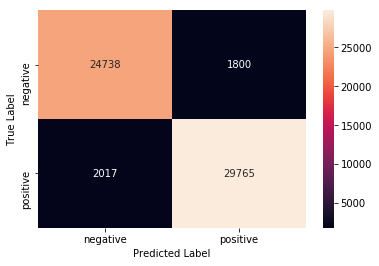




Test Confusion Matrix


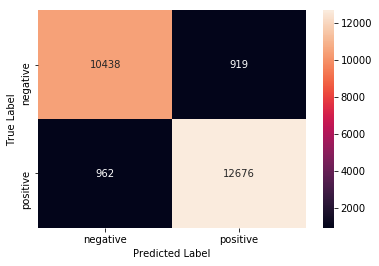

In [166]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf", "SGD Linear SVM", tfIdf_alpha,
               auc_score])

In [168]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     11357
           1       0.93      0.93      0.93     13638

   micro avg       0.92      0.92      0.92     24995
   macro avg       0.92      0.92      0.92     24995
weighted avg       0.92      0.92      0.92     24995



In [172]:
# Top 10 positive features
print("Top 10 positive features are : ")
print(np.take(tf_idf_vect.get_feature_names(), 
              classifier.coef_[0].argsort()[:-11:-1]))

Top 10 positive features are : 
['great' 'best' 'delicious' 'good' 'excellent' 'loves' 'perfect' 'love'
 'awesome' 'yummy']


In [173]:
# Top 10 negative features
print("Top 10 negative features are : ")
print(np.take(tf_idf_vect.get_feature_names(), 
              (-classifier.coef_[0]).argsort()[:-11:-1]))

Top 10 negative features are : 
['not' 'disappointed' 'not good' 'disappointing' 'worst' 'terrible'
 'not worth' 'horrible' 'awful' 'unfortunately']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

Optimal Parameters :  {'alpha': 0.001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': None, 'n_iter': None, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': None, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
(16,)
(16,)


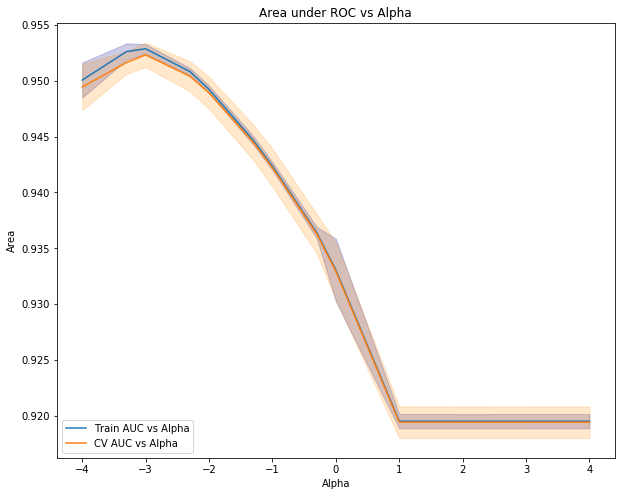

In [174]:
# Please write all the code with proper documentation
SgdSvm_Classifier(avgW2V_train, rs_train)

Using Alpha value for sgd-SVM -  0.0001
Train accuracy for optimal sgd-SVM  88.76
Test accuracy for optimal sgd-SVM  88.95


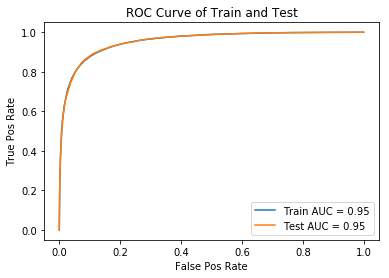

In [179]:
# Please write all the code with proper documentation
avgW2V_alpha=0.0001
classifier, pred_train, pred_test, auc_score = SgdSvm_Classifier_Test(
                                    avgW2V_alpha, avgW2V_train, 
                                    rs_train, avgW2V_test, 
                                    rs_test)

Training Confusion Matrix


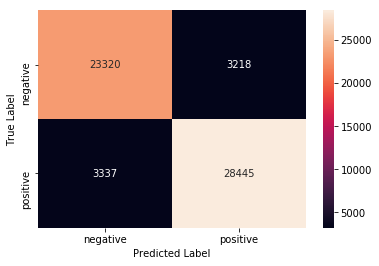




Test Confusion Matrix


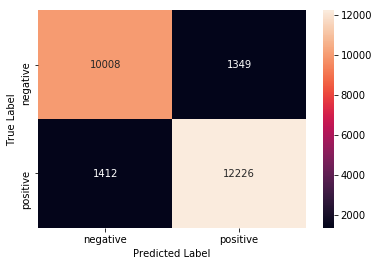

In [180]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Avg W2V", "SGD Linear SVM", avgW2V_alpha,
               auc_score])

In [181]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11357
           1       0.90      0.90      0.90     13638

   micro avg       0.89      0.89      0.89     24995
   macro avg       0.89      0.89      0.89     24995
weighted avg       0.89      0.89      0.89     24995



### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

Optimal Parameters :  {'alpha': 0.001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': None, 'n_iter': None, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': None, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
(16,)
(16,)


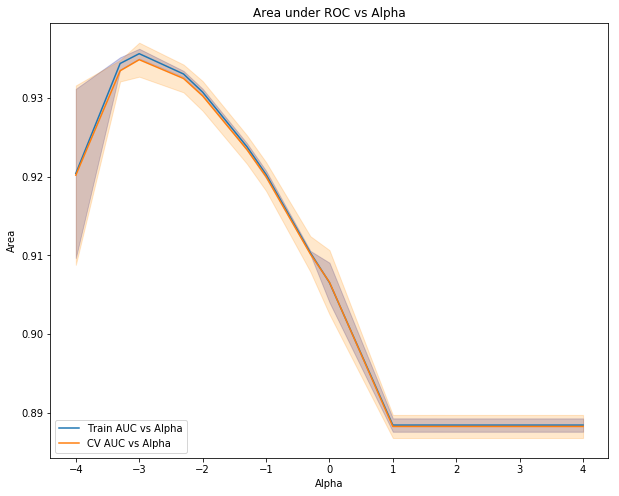

In [191]:
# Please write all the code with proper documentation
SgdSvm_Classifier(tfidf_avgW2V_train, rs_train)

Using Alpha value for sgd-SVM -  0.001
Train accuracy for optimal sgd-SVM  86.51
Test accuracy for optimal sgd-SVM  86.25


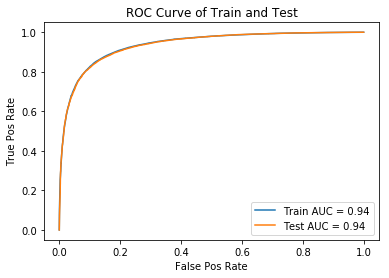

In [192]:
# Please write all the code with proper documentation
tfIdfAvgW2V_alpha=0.001
classifier, pred_train, pred_test, auc_score = SgdSvm_Classifier_Test(
                                    tfIdfAvgW2V_alpha, tfidf_avgW2V_train, 
                                    rs_train, tfidf_avgW2V_test, 
                                    rs_test)

Training Confusion Matrix


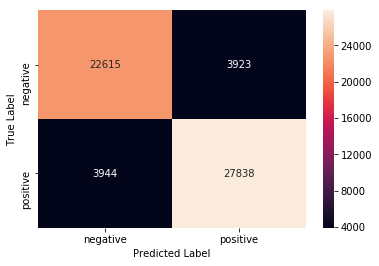




Test Confusion Matrix


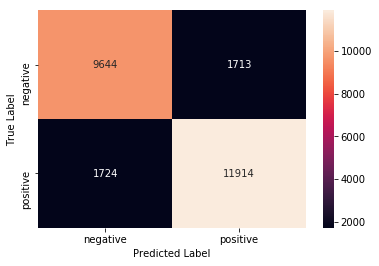

In [193]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf Avg W2V", "SGD Linear SVM", tfIdfAvgW2V_alpha,
               auc_score])

In [194]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     11357
           1       0.87      0.87      0.87     13638

   micro avg       0.86      0.86      0.86     24995
   macro avg       0.86      0.86      0.86     24995
weighted avg       0.86      0.86      0.86     24995



## [5.2] RBF SVM

In [ ]:
# Its running for 1 day without any results for 40k data points. 
# Reducing data to 20k
# For RBF SVM we will use 15k train and 5k test points.

In [110]:
ppText_train, ppText_test, rs_train, rs_test = [],[],[],[]
pptrO, pptstO = 0, 0
for i, p in enumerate(preprocessed_text):
    if review_score[i]==0:
        if pptrO <7500:
            ppText_train.append(p)
            rs_train.append(0)
            pptrO += 1
        elif pptstO <2500:
            ppText_test.append(p)
            rs_test.append(0)
            pptstO += 1
    elif review_score[i] ==1:
        if len(ppText_train)-pptrO <7500:
            ppText_train.append(p)
            rs_train.append(1)
        elif len(ppText_test)-pptstO <2500:
            ppText_test.append(p)
            rs_test.append(1)
    else:
        pass
    if len(ppText_train)==15000 and len(ppText_test)==5000:
        break

In [115]:
#BoW
fullPath = dir_path+'models/'+'bow_vectors_rbf.pickle'
useOldData = False
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10,
                          max_features=500) #in scikit-learn
count_vect.fit(ppText_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        bow_train, bow_test = pickle.load(f)
    
else:
    bow_train = count_vect.transform(ppText_train)
    bow_test = count_vect.transform(ppText_test)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump((bow_train, bow_test), f)

print("\nShapes After Vectorization ")
print("Train shape ", bow_train.shape, len(rs_train))
print("Test shape  ", bow_test.shape, len(rs_test))
print("Unique words in training : ", bow_train.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'also', 'although', 'always']

Shapes After Vectorization 
Train shape  (15000, 500) 15000
Test shape   (5000, 500) 5000
Unique words in training :  500


In [185]:
#tf-Idf
fullPath = dir_path+'models/'+'tfIdf_vectors_rbf.pickle'
useOldData=True
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,
                             max_features=500)
tf_idf_vect.fit(ppText_train)
print("Some sample features(unique words in the training corpus)",
    tf_idf_vect.get_feature_names()[0:10])
print('='*50)
if os.path.isfile(fullPath) and useOldData:
    print("Reading vectors from drive..")
    with open(fullPath, 'rb') as f:
        tfIdf_train, tfIdf_test = pickle.load(f)
    
else:
    tfIdf_train = tf_idf_vect.transform(ppText_train)
    tfIdf_test = tf_idf_vect.transform(ppText_test)
  
    # Save the vectors
    with open(fullPath,'wb') as f:
        pickle.dump((tfIdf_train, tfIdf_test), f)


print("\nShapes After Vectorization ")
print("Train shape ", tfIdf_train.shape, len(rs_train))
print("Test shape  ", tfIdf_test.shape, len(rs_test))
print("Unique words in training : ", tfIdf_train.get_shape()[1])

Some sample features(unique words in the training corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almost', 'also', 'although', 'always']

Shapes After Vectorization 
Train shape  (15000, 500) 15000
Test shape   (5000, 500) 5000
Unique words in training :  500


In [190]:
# Avg W2V

# Train your own Word2Vec model using your own text corpus
i=0

# list of sentences divided into train and test set
train_sentences = [sentence.split() for sentence in ppText_train]
test_sentences = [sentence.split() for sentence in ppText_test]

In [191]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True
fullPath = dir_path+'models/'+'w2V_model_rbf.pickle'
useOldData=True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    if os.path.isfile(fullPath) and useOldData:
        with open(fullPath, 'rb') as f:
            w2v_model = pickle.load(f)
    else:
        w2v_model=Word2Vec(train_sentences,min_count=5,size=128, workers=4)
        # Save word2Vec model
        with open(fullPath,'wb') as f:
            pickle.dump(w2v_model, f)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format(
                      'GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep \
          want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8453381061553955), ('excellent', 0.8048703670501709), ('wonderful', 0.7937352657318115), ('amazing', 0.7792501449584961), ('awesome', 0.7622500658035278), ('fantastic', 0.7570558786392212), ('perfect', 0.7455378174781799), ('delicious', 0.7233303785324097), ('yummy', 0.7231276631355286), ('love', 0.7105463743209839)]
[('ever', 0.8869836330413818), ('eaten', 0.8469640612602234), ('remember', 0.7808690071105957), ('trinidad', 0.7737390995025635), ('disgusting', 0.7705298662185669), ('experience', 0.7632001042366028), ('best', 0.7525022029876709), ('tasted', 0.7455431222915649), ('far', 0.7422235608100891), ('folgers', 0.7404943108558655)]


In [192]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8076
sample words  ['one', 'best', 'children', 'books', 'ever', 'written', 'mini', 'version', 'book', 'not', 'priced', 'product', 'sent', 'email', 'regarding', 'amazon', 'got', 'no', 'response', 'awesome', 'poor', 'size', 'give', 'five', 'stars', 'story', 'star', 'printed', 'edition', 'older', 'copy', 'familiar', 'previous', 'ordered', 'embarrassed', 'gift', 'looks', 'think', 'overpriced', 'learned', 'lesson', 'buying', 'next', 'time', 'get', 'used', 'great', 'disappointing', 'dogs', 'loves']


In [194]:
fullPath = dir_path+'models/'+'avg_W2V_rbf.pickle'
useOldData=True

# average Word2Vec

avgW2V_train, avgW2V_test = [], []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        avgW2V_train, avgW2V_test = pickle.load(f)
    
else:
    for i, sent_set in enumerate([train_sentences, test_sentences]):
        for sent in sent_set:
            c += 1
            if c % 1000==0:
                print("Progress : {:3d} %  ".format(
                        int(c/len(preprocessed_reviews)*100)),
                        end='\r')
            sent_vec = np.zeros(128)
            cnt_words = 0
            for word in sent:
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    sent_vec += vec
                    cnt_words += 1
            if cnt_words != 0:
                sent_vec /= cnt_words
            if i==0:
                avgW2V_train.append(sent_vec)
            if i==1:
                avgW2V_test.append(sent_vec)
  
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump((avgW2V_train, avgW2V_test), f)

print("Dims of Train : ({}, {})".format(len(avgW2V_train), 
                                        len(avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(avgW2V_test), 
                                       len(avgW2V_test[0])))

Saving to drive.. 
Dims of Train : (15000, 128)
Dims of Test : (5000, 128)


In [200]:
# Tf-Idf weighted Word2Vec
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=5)
tf_idf_matrix = model.fit_transform(ppText_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [201]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, 
# col=word and cell_val = tfidf

fullPath = dir_path+'models/'+'tfIdf_avg_W2V_rbf.pickle'
useOldData=True

tfidf_avgW2V_train, tfidf_avgW2V_test = [], []
c = 0

if os.path.isfile(fullPath) and useOldData:
    print("Vectors loaded from drive..")
    with open(fullPath, 'rb') as f:
        tfidf_avgW2V_train, tfidf_avgW2V_test = pickle.load(f)
    
else:
    for i, sent_set in enumerate([train_sentences, test_sentences]):
        for sent in sent_set:
            c += 1
            if c % 1000==0:
                print("Progress : {:3d} %  ".format(
                        int(c/len(preprocessed_reviews)*100)), 
                        end='\r')
            sent_vec = np.zeros(128)
            weight_sum = 0
            for word in sent:
                if word in w2v_words and word in tfidf_feat:
                    vec = w2v_model.wv[word]
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
            if weight_sum != 0:
                sent_vec /= weight_sum
            if i==0:
                tfidf_avgW2V_train.append(sent_vec)
            if i==1:
                tfidf_avgW2V_test.append(sent_vec)
              
    print("Saving to drive..")
    with open(fullPath,'wb') as f:
        pickle.dump((tfidf_avgW2V_train, tfidf_avgW2V_test), f)
    

print("Dims of Train : ({}, {})".format(len(tfidf_avgW2V_train), 
                                        len(tfidf_avgW2V_train[0])))
print("Dims of Test : ({}, {})".format(len(tfidf_avgW2V_test), 
                                       len(tfidf_avgW2V_test[0])))

Saving to drive.. 
Dims of Train : (15000, 128)
Dims of Test : (5000, 128)


In [116]:
from sklearn.svm import SVC

In [169]:
def SvcSvm_Classifier(X_train, y_train):
    cList = [0.001, 0.01, 0.1, 1, 10]
    gammaList = [0.001, 0.01, 0.1, 1, 10]
    params_dict = [{'C': cList, 'gamma': gammaList}]
    svc_optimal = SVC(kernel='rbf')
    
    grid = GridSearchCV(estimator=svc_optimal, 
                        param_grid=params_dict, 
                        scoring='roc_auc', n_jobs=5, cv=5)
    
    grid_result = grid.fit(X_train, y_train)
    train_auc = grid_result.cv_results_['mean_train_score']
    train_auc_std = grid_result.cv_results_['std_train_score']
    cv_auc = grid_result.cv_results_['mean_test_score']
    cv_auc_std = grid_result.cv_results_['std_test_score']
    
    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
    
    
    plt.figure(figsize=(10.0, 8.0))
    ax = sns.heatmap(train_auc.reshape(len(gammaList),len(cList)), 
                     annot=True, square=False,  cmap="Oranges",
                     xticklabels=["g = "+str(g) for g in gammaList],
                     yticklabels=["c = "+str(c) for c in cList])
    plt.title("Training scores for C and gamma")
    plt.show()
    print('')
    
    plt.figure(figsize=(10.0, 8.0))
    ax = sns.heatmap(cv_auc.reshape(len(gammaList),len(cList)), 
                     annot=True, square=False,  cmap="Blues",
                     xticklabels=["g = "+str(g) for g in gammaList],
                     yticklabels=["c = "+str(c) for c in cList])
    plt.title("Cross-val scores for C and gamma")
    plt.show()

In [173]:
def SvcSvm_Classifier_Test(C, gamma, X_train, y_train, X_test, y_test):
    # Setting up the classifier using optimal params

    svc_optimal = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
    
    # we have to fit the SGDClassifier so that we can access the coef_
    svc_optimal.fit(X_train, y_train)
    
    # Prediction on training and test set using optimal classifier
    logProb_train = svc_optimal.predict_log_proba(X_train)
    logProb_test = svc_optimal.predict_log_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    print("Using C value for svc-SVM - ", C)
    print("Using gamma value for svc-SVM - ", gamma)
    print("Train accuracy for optimal svc-SVM ", round(
                        accuracy_score(y_train, pred_train)*100, 2))
    print("Test accuracy for optimal svc-SVM ", round(
                        accuracy_score(y_test, pred_test) * 100, 2))

    # ROC-AUC on train & test data
    train_fpr, train_tpr, thresholds = roc_curve(y_train, 
                                logProb_train[:, 1], pos_label=1)
    test_fpr, test_tpr, thresholds = roc_curve(y_test, 
                                logProb_test[:, 1], pos_label=1)


    # Draw ROC curve
    plt.plot(train_fpr, train_tpr, label="Train AUC = "+str(round(
                                    auc(train_fpr, train_tpr), 2)))
    auc_score = round(auc(test_fpr, test_tpr), 2)
    plt.plot(test_fpr, test_tpr, label="Test AUC = "+str(auc_score))
    plt.legend()
    plt.xlabel("False Pos Rate")
    plt.ylabel("True Pos Rate")
    plt.title("ROC Curve of Train and Test")
    plt.show()
    
    return svc_optimal, pred_train, pred_test, auc_score

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

Optimal Parameters :  {'C': 1, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


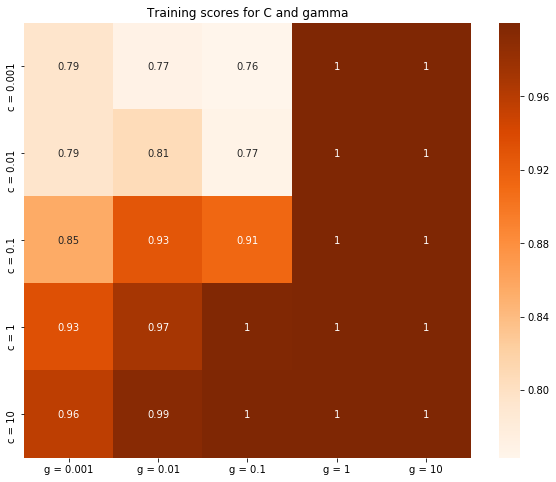

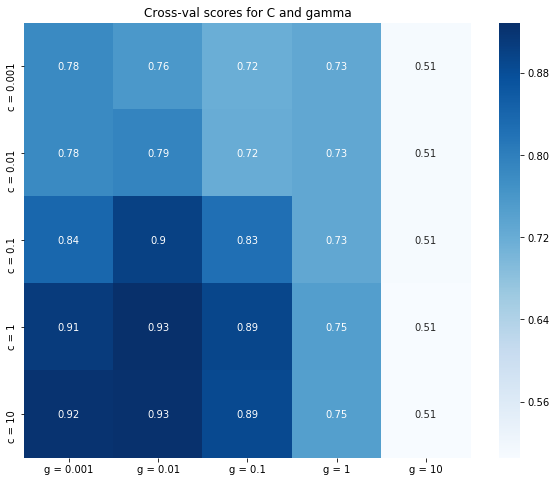

In [170]:
# Please write all the code with proper documentation
SvcSvm_Classifier(bow_train, rs_train)

Using C value for svc-SVM -  1
Using gamma value for svc-SVM -  0.01
Train accuracy for optimal svc-SVM  91.24
Test accuracy for optimal svc-SVM  87.86


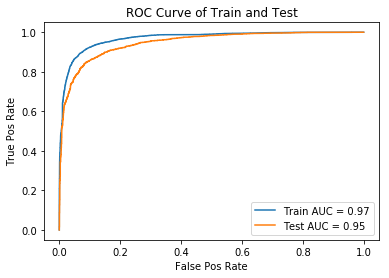

In [174]:
# Please write all the code with proper documentation
bow_C, bow_gamma = 1, 0.01
classifier, pred_train, pred_test, auc_score = SvcSvm_Classifier_Test(
                                    bow_C, bow_gamma, bow_train, 
                                    rs_train, bow_test, 
                                    rs_test)

Training Confusion Matrix


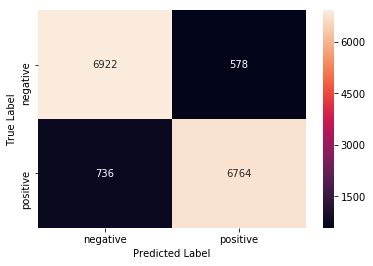




Test Confusion Matrix


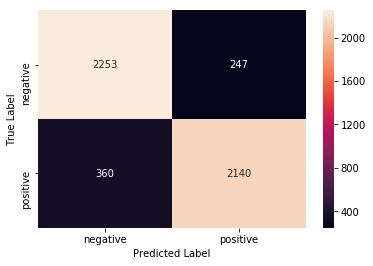

In [178]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["BOW", "RBF Support Vector Machine", 
               "c: {0}  gamma: {1}".format(bow_C, bow_gamma), 
               auc_score])

In [180]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2500
           1       0.90      0.86      0.88      2500

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

Optimal Parameters :  {'C': 1, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


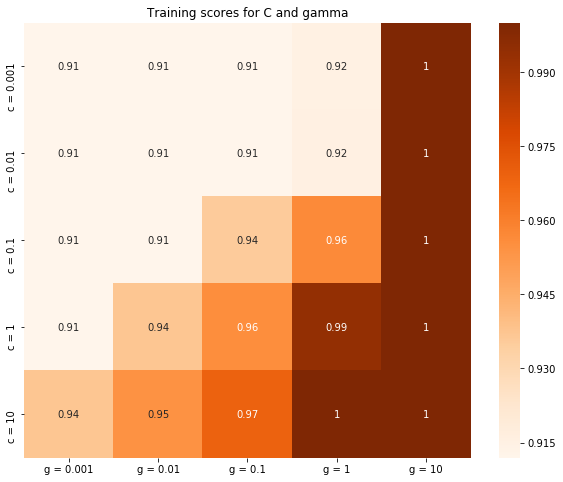

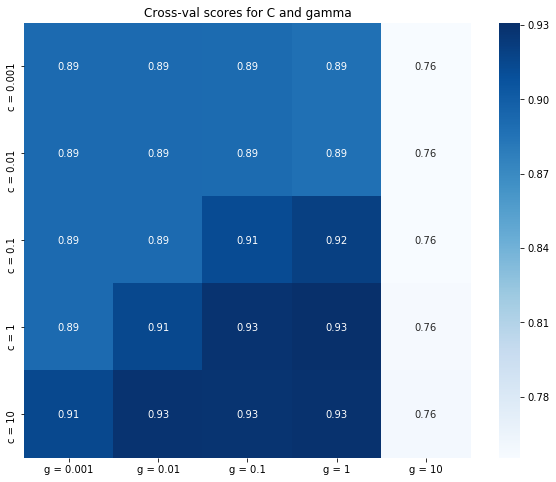

In [186]:
# Please write all the code with proper documentation
SvcSvm_Classifier(tfIdf_train, rs_train)

Using C value for svc-SVM -  1
Using gamma value for svc-SVM -  1
Train accuracy for optimal svc-SVM  96.31
Test accuracy for optimal svc-SVM  88.2


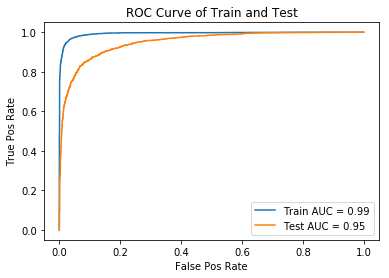

In [187]:
# Please write all the code with proper documentation
tfIdf_C, tfIdf_gamma =1, 1
classifier, pred_train, pred_test, auc_score = SvcSvm_Classifier_Test(
                                    tfIdf_C, tfIdf_gamma, tfIdf_train, 
                                    rs_train, tfIdf_test, 
                                    rs_test)

Training Confusion Matrix


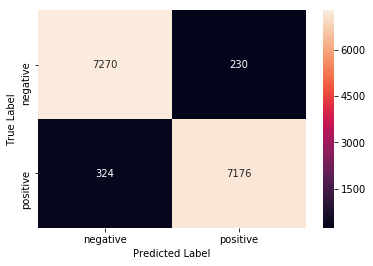




Test Confusion Matrix


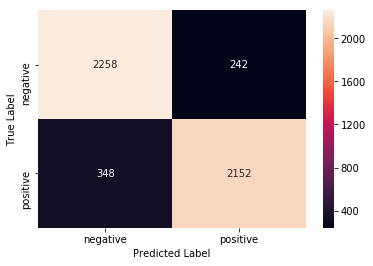

In [188]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Tf-Idf", "RBF Support Vector Machine", 
               "c: {0}  gamma: {1}".format(tfIdf_C, tfIdf_gamma), 
               auc_score])

In [189]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2500
           1       0.90      0.86      0.88      2500

   micro avg       0.88      0.88      0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

Optimal Parameters :  {'C': 10, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


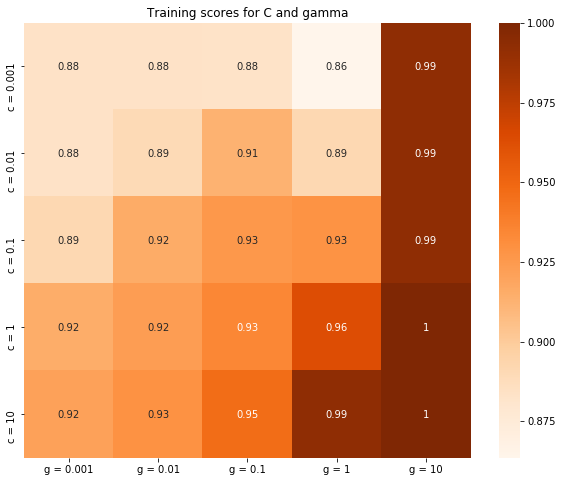

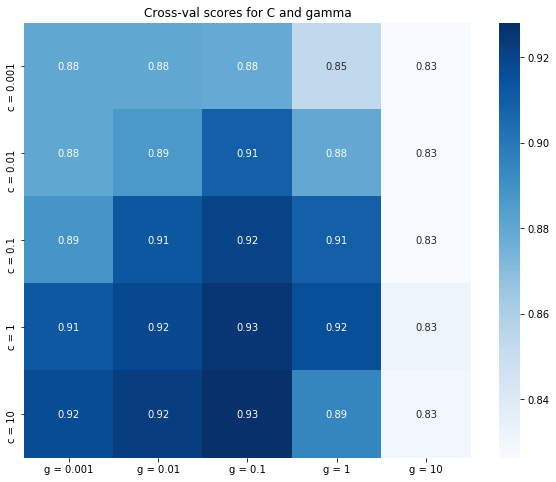

In [195]:
# Please write all the code with proper documentation
SvcSvm_Classifier(avgW2V_train, rs_train)

Using C value for svc-SVM -  10
Using gamma value for svc-SVM -  0.1
Train accuracy for optimal svc-SVM  87.63
Test accuracy for optimal svc-SVM  87.12


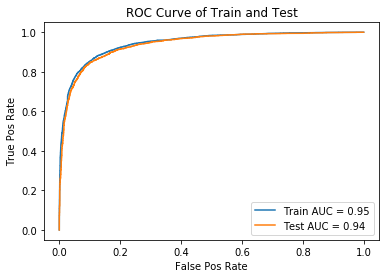

In [196]:
# Please write all the code with proper documentation
avgW2V_C, avgW2V_gamma =10, 0.1
classifier, pred_train, pred_test, auc_score = SvcSvm_Classifier_Test(
                                    avgW2V_C, avgW2V_gamma, avgW2V_train, 
                                    rs_train, avgW2V_test, 
                                    rs_test)

Training Confusion Matrix


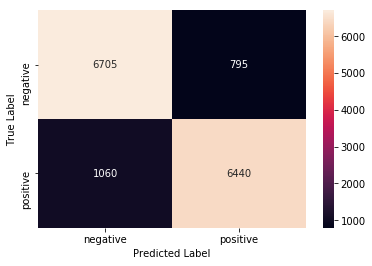




Test Confusion Matrix


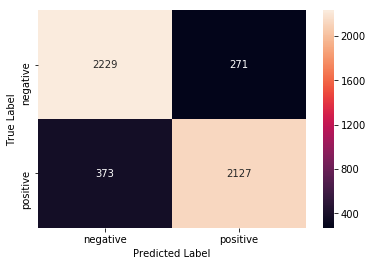

In [197]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["Avg W2V", "RBF Support Vector Machine", 
               "c: {0}  gamma: {1}".format(avgW2V_C, avgW2V_gamma), 
               auc_score])

In [198]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2500
           1       0.89      0.85      0.87      2500

   micro avg       0.87      0.87      0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

Optimal Parameters :  {'C': 10, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


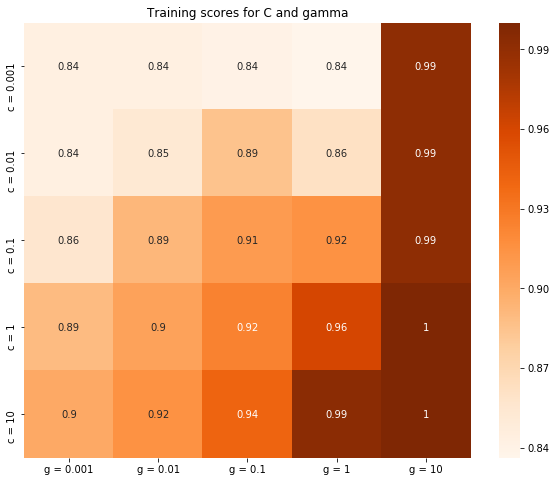

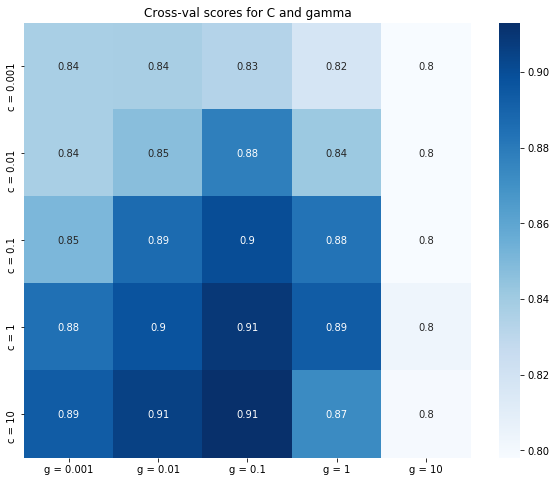

In [202]:
# Please write all the code with proper documentation
SvcSvm_Classifier(tfidf_avgW2V_train, rs_train)

Using C value for svc-SVM -  10
Using gamma value for svc-SVM -  0.1
Train accuracy for optimal svc-SVM  86.84
Test accuracy for optimal svc-SVM  84.98


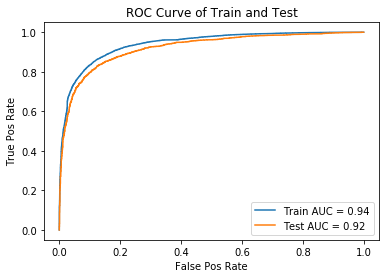

In [203]:
# Please write all the code with proper documentation
tfIdfavgW2V_C, tfIdfavgW2V_gamma = 10, 0.1
classifier, pred_train, pred_test, auc_score = SvcSvm_Classifier_Test(
                        tfIdfavgW2V_C, tfIdfavgW2V_gamma, tfidf_avgW2V_train, 
                                rs_train, tfidf_avgW2V_test, 
                                rs_test)

Training Confusion Matrix


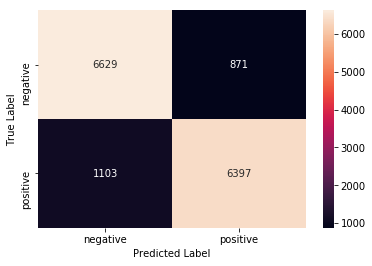




Test Confusion Matrix


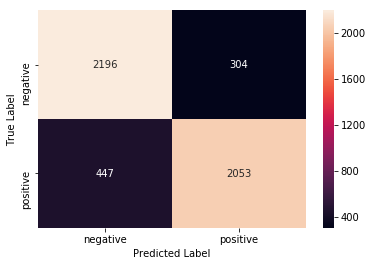

In [204]:
print("Training Confusion Matrix")
draw_Confusion_Matrix(rs_train, pred_train)
print('\n\n')

print("Test Confusion Matrix")
draw_Confusion_Matrix(rs_test, pred_test)
table.add_row(["TfIdf Avg W2V", "RBF Support Vector Machine", 
               "c: {0}  gamma: {1}".format(tfIdfavgW2V_C, tfIdfavgW2V_gamma), 
               auc_score])

In [205]:
# Classification report 
print(classification_report(rs_test, pred_test))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      2500
           1       0.87      0.82      0.85      2500

   micro avg       0.85      0.85      0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



# [6] Conclusions

In [230]:
# Please compare all your models using Prettytable library
print(table)

+---------------+----------------------------+-------------------+-----------+
|   Vectorizer  |           Model            |  Hyperparameters  | AUC Score |
+---------------+----------------------------+-------------------+-----------+
|      BOW      | RBF Support Vector Machine | c: 1  gamma: 0.01 |    0.95   |
|     Tf-Idf    | RBF Support Vector Machine |   c: 1  gamma: 1  |    0.95   |
|    Avg W2V    | RBF Support Vector Machine | c: 10  gamma: 0.1 |    0.94   |
| TfIdf Avg W2V | RBF Support Vector Machine | c: 10  gamma: 0.1 |    0.92   |
|      BOW      |       SGD Linear SVM       |    alpha: 0.001   |    0.97   |
|     Tf-Idf    |       SGD Linear SVM       |   alpha: 0.0001   |    0.98   |
|    Avg W2V    |       SGD Linear SVM       |   alpha: 0.0001   |    0.95   |
| TfIdf Avg W2V |       SGD Linear SVM       |    alpha: 0.001   |    0.94   |
+---------------+----------------------------+-------------------+-----------+


    - We observe that in case of linear SVM (which is almost like Logistic 
        Regression), the alpha value remained either 0.001 or 0.0001 and we get
        good values of AUC score (>0.90)
        
    - The linear kernel is also pretty fast as it involves simple computations 
        which can be vectorised and made fast compared to the rbf kernel
        
    - While we use support vector machine with the rbf kernel we observe a huge
        leap in the runtime as the kernel is very complex compared to rbf
        
    - When we are working with bow and tf-Idf vectors, we have lots of features 
        thus more focus is on regularisation (C = 1) and working with average and
        tf-Idf weighted average word2Vec focus to fitting the data points in a 
        more better way, so increase C